# To do

- One hot encode data (Complete)
- Rework windowing function (Complete)
- Fix Neural Network to work with OHE Data (Complete)
- Include SMAPE in Neural Network (Complete)
- Work on forecasting portion (Complete)
- Expand dataset so that it includes all stores and items (500 trendlines) (Almost done)
- Optimize neural network. Consider using Conv1D layer? Another LSTM layer? (In Progress)

# Introduction

This is a demand forecaster for the kaggle competition at https://www.kaggle.com/c/demand-forecasting-kernels-only using a LSTM neural network

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable

import torch as torch
import torch.nn as nn

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = parse_dates)
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = parse_dates)

In [3]:
train.sample(10)

,date,store,item,sales
243880,2015-10-20,4,14,51
816047,2017-07-10,7,45,60
800776,2015-09-16,9,44,33
11410,2014-03-31,7,1,16
215598,2013-05-11,9,12,70
777774,2017-09-21,6,43,40
846122,2014-11-16,4,47,32
758990,2016-04-15,6,42,37
728694,2013-05-01,10,40,26
724767,2017-07-30,7,40,29


So there are 10 stores with 50 different products. The sales for each item range between 0 and 231, but they are mainly around the 30-70 range. There is five years worth of sales data (2013-2017) to train on and the goal is the predict the sales for the next 3 months.

## Preprocessing
Here we create a windowed dataset to preprocess the data

In [4]:
# Include other date information to be processed
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year - 2013 # Subtract earliest year to help normalize this information

In [5]:
# One Hot Encode data
columns_OHE = train.columns[((train.columns != 'sales') & (train.columns != 'date')) & (train.columns != 'year')]
train_OHE = pd.get_dummies(train, columns = columns_OHE)

In [6]:
OHE_cols = train_OHE.columns

In [7]:
# Take a sample of only one item in one store to test neural network
sample = train_OHE.loc[(train['store'] == 5) & (train['item'] == 1) & (train['year'] <= 3)]

In [8]:
def create_data_windows(df, width):
    """
    Function: Takes in the DataFrame, df, and splits it into rolling windows of size width to be used in a neural network.
    It outputs a dataframe and a target dataframe, which is the sales number to be predicted. The other information such
    as year, day of the week, are all taken from the target.
    Inputs: df - dataframe with columns [date, store, item, sales]
            width - the with of the window including the last sales data which will be the target
    Outputs: df_windowed - dataframe with the day of the week of the last day of the window, the store, and item numbers
                            along with the windowed sales data
             df_target - dataframe that contains the target date and target sales
    """
    # Retrieve column names that are not date nor sales
    other_columns = df.columns[((df.columns != 'sales') & (df.columns != 'date'))]
    
    # Initalize output datasets
    windowed_data = np.empty([len(df)-width+1, width - 1])
    df = df.reset_index(drop = True)
    
    # Create windows. E.g. [1, 2, 3, 4, 5, 6, 7] -> [[1,2,3,4], [2,3,4,5], [3,4,5,6]]
    # Also creates targets which would be [[5], [6], [7]] in the above case
    for i in range(len(df)-width+1):
        windowed_data[i] = list(df.iloc[i:i+width-1]['sales'])
        
        
    # Create a DataFrame to contain the windowed data
    windowed_columns = list(map(str,(range(1,width))))
    
    df_temp = pd.DataFrame(data = windowed_data, 
                               columns = windowed_columns,
                               dtype = 'int')
    # Create a DataFrame containing store, year, etc. information and combine with windowed data
    df_other = df.loc[width-1::, other_columns].reset_index(drop = True)
    
    df_windowed = pd.concat([df_temp, df_other], axis = 1)
    
    # Create target dataset
    df_target = pd.DataFrame(data = df.loc[width-1::, ['date', 'sales']]).reset_index(drop = True)
        
    return df_windowed, df_target

In [9]:
window_size = 30
df, df_target = create_data_windows(sample, window_size + 1)

In [10]:
df_target

,date,sales
0,2013-01-31,6
1,2013-02-01,6
2,2013-02-02,20
3,2013-02-03,13
4,2013-02-04,12
...,...,...
1426,2016-12-27,9
1427,2016-12-28,6
1428,2016-12-29,23
1429,2016-12-30,16


In [11]:
# Train-test split
sample_train_df, sample_train_target = df.iloc[:-365], df_target.iloc[:-365]
sample_val_df, sample_val_target = df.iloc[-365::], df_target.iloc[-365::]

In [12]:
sample_train_df

,1,2,3,4,5,6,7,8,9,10,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,11,9,12,8,13,15,6,11,13,9,...,0,0,0,0,0,0,0,0,0,0
1,9,12,8,13,15,6,11,13,9,9,...,0,0,0,0,0,0,0,0,0,0
2,12,8,13,15,6,11,13,9,9,8,...,0,0,0,0,0,0,0,0,0,0
3,8,13,15,6,11,13,9,9,8,22,...,0,0,0,0,0,0,0,0,0,0
4,13,15,6,11,13,9,9,8,22,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,17,29,12,12,20,12,17,7,10,15,...,0,0,0,0,0,0,0,0,0,1
1062,29,12,12,20,12,17,7,10,15,15,...,0,0,0,0,0,0,0,0,0,1
1063,12,12,20,12,17,7,10,15,15,9,...,0,0,0,0,0,0,0,0,0,1
1064,12,20,12,17,7,10,15,15,9,15,...,0,0,0,0,0,0,0,0,0,1


In [13]:
sample_train_target

,date,sales
0,2013-01-31,6
1,2013-02-01,6
2,2013-02-02,20
3,2013-02-03,13
4,2013-02-04,12
...,...,...
1061,2015-12-28,13
1062,2015-12-29,15
1063,2015-12-30,8
1064,2015-12-31,15


Turn dataframes into tensors to prepare them to be fed into neural network in pytorch

In [14]:
training_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_train_df)), torch.FloatTensor(np.array(sample_train_target['sales'])))
validation_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_val_df)), torch.FloatTensor(np.array(sample_val_target['sales'])))

# Neural Network

Initalize Neural Network

In [110]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias,0)
        
def SMAPE(y_true, y_pred):
    """ Returns the standard mean absolute percent error in %
    """
    return np.mean(200*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
        
class Net(nn.Module):
    def __init__(self, num_cols, window_length, n_hidden_1=32, n_hidden_2=32, n_hidden_3=32, n_hidden_4 = 32, D_out=1):
        super().__init__()
        
        self.window_length = window_length
        self.num_cols = num_cols
        
        # LSTM Layer
        self.lstm1 = nn.LSTM(1, n_hidden_1, bidirectional = False, batch_first = True)
        
        # Densely Connected Layers
        self.fc1 = nn.Linear(n_hidden_1 + num_cols - self.window_length, n_hidden_2)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_2, n_hidden_3)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_3, n_hidden_4)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(n_hidden_4, D_out)
        self.out_act = nn.ReLU()
        
    def forward(self, x):
        # Split input tensor. x_seq will be fed into the lstm.
        x_seq, x_info = x[:,:self.window_length], x[:,self.window_length:]
        
        # LSTM layer
        x_seq = torch.unsqueeze(x_seq, 2)
        lstm_out, (h, c) = self.lstm1(x_seq)
        
        # Combine the extra info to the lstm results using the output of the last lstm neuron
        lstm_output = torch.squeeze(lstm_out[:,-1,:], dim = 1)
        
        combined_out = torch.cat([lstm_output, x_info], 1)
        
        # Fully connected layer 1
        fc1_out = self.fc1(combined_out)
        fc1_out = self.relu1(fc1_out)
        
        # Fully connected layer 2
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.relu2(fc2_out)
        
        # Fully connected layer 3
        fc3_out = self.fc3(fc2_out)
        fc3_out = self.relu3(fc3_out)
        
        # Output layer
        y = self.out_act(self.fc4(fc3_out))
        
        # Squeeze to remove extra dimensions of size 1
        return torch.squeeze(y)

In [111]:
def train_model(data_set, model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    model.train()
    loss_accuracy = {'training_loss':[], 'validation_loss':[],'validation_smape':[], 'validation_precision':[], 'validation_recall':[]}
    
    training_size = (len(list(train_loader))-1)*len(list(train_loader)[0][0]) + len(list(train_loader)[-1][0])
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        print("Epoch {} / {}\n=============".format(epoch+1, epochs))
            
        train_smape_sum = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            ## Forward pass
            yhat = model(x)
            ## Compute loss
            train_loss = criterion(yhat, y)
            ## Compute gradient in backward pass
            train_loss.backward()
            ## Update weights
            optimizer.step()
            
            train_smape_sum += SMAPE(y.numpy(), yhat.detach().numpy()) * len(x)
            
            loss_accuracy['training_loss'].append(train_loss.item())
         
        ## Compute validation accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = net(x)
            val_loss = criterion(yhat, y)                     
            val_smape = SMAPE(y.numpy(), yhat.detach().numpy())
            
        # Calculate loss values
        train_smape = train_smape_sum / training_size
        
        loss_accuracy['validation_loss'].append(val_loss.item())
        loss_accuracy['validation_smape'].append(val_smape)
        
        
        ## Print training loss and accuracy, and validation accuracy
        
        print("Training mean squared error: {:.3f} | Training SMAPE: {:.2f}\nValidation mean squared error: {:.3f} | Validation SMAPE: {:.2f}".format(
            train_loss.item(), train_smape, val_loss.item(), val_smape))
        
        model.train()
        
        ## Add precision and recall
        
    print("Training complete!")
                
    return loss_accuracy

In [112]:
learning_rate = 0.0005

## Network dimensions
num_cols = len(sample_train_df.columns)
n_hidden_1 = 32
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 32
D_out = 1
batch_size = 64
reg_lambda = 0
momentum_coef = 0.9
dropout_percent = 0.0

## Load data
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize model
net = Net(num_cols, window_size, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, D_out)
net.apply(weights_init)


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
criterion = nn.MSELoss()

In [113]:
epochs = 100
## Train the model
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

Epoch 1 / 100
Training mean squared error: 231.896 | Training SMAPE: 182.59
Validation mean squared error: 306.137 | Validation SMAPE: 165.17
Epoch 2 / 100
Training mean squared error: 202.309 | Training SMAPE: 150.10
Validation mean squared error: 242.096 | Validation SMAPE: 127.49
Epoch 3 / 100
Training mean squared error: 127.434 | Training SMAPE: 99.33
Validation mean squared error: 132.863 | Validation SMAPE: 70.15
Epoch 4 / 100
Training mean squared error: 22.214 | Training SMAPE: 41.86
Validation mean squared error: 41.108 | Validation SMAPE: 27.57
Epoch 5 / 100
Training mean squared error: 36.660 | Training SMAPE: 28.50
Validation mean squared error: 35.927 | Validation SMAPE: 26.46
Epoch 6 / 100
Training mean squared error: 35.859 | Training SMAPE: 27.11
Validation mean squared error: 37.206 | Validation SMAPE: 26.27
Epoch 7 / 100
Training mean squared error: 41.893 | Training SMAPE: 26.33
Validation mean squared error: 34.893 | Validation SMAPE: 25.60
Epoch 8 / 100
Training m

Training mean squared error: 15.007 | Training SMAPE: 20.94
Validation mean squared error: 21.628 | Validation SMAPE: 21.22
Epoch 56 / 100
Training mean squared error: 17.132 | Training SMAPE: 20.87
Validation mean squared error: 21.632 | Validation SMAPE: 21.22
Epoch 57 / 100
Training mean squared error: 17.353 | Training SMAPE: 20.87
Validation mean squared error: 21.402 | Validation SMAPE: 21.11
Epoch 58 / 100
Training mean squared error: 13.722 | Training SMAPE: 20.85
Validation mean squared error: 21.418 | Validation SMAPE: 21.03
Epoch 59 / 100
Training mean squared error: 14.622 | Training SMAPE: 20.92
Validation mean squared error: 21.457 | Validation SMAPE: 21.04
Epoch 60 / 100
Training mean squared error: 16.179 | Training SMAPE: 21.04
Validation mean squared error: 22.081 | Validation SMAPE: 21.57
Epoch 61 / 100
Training mean squared error: 15.438 | Training SMAPE: 20.77
Validation mean squared error: 21.898 | Validation SMAPE: 21.46
Epoch 62 / 100
Training mean squared error

Text(0, 0.5, 'Validation SMAPE [%]')

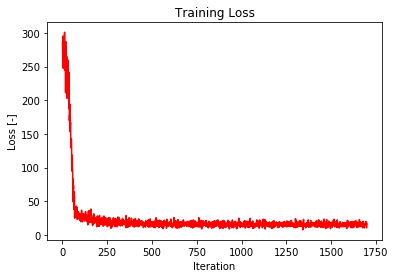

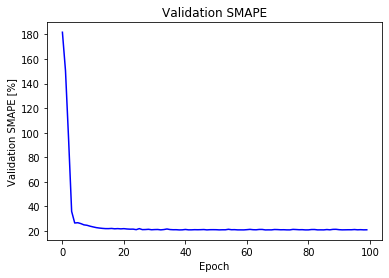

In [71]:
## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_smape'], color="blue")
plt.title("Validation SMAPE")
plt.xlabel("Epoch")
plt.ylabel("Validation SMAPE [%]")

# Forecasting

In [79]:
def model_forecast(model, df, start_date, end_date, store_num, item_num, col_names):
    """
    This function creates a loop to forecast sales data into the future.
    Inputs: model: The trained neural network model (pytorch model)
            df: The dataframe containing the known past sequence data (dataframe)
            start_date: The first forecast date (datetime string)
            end_date: The last forecast date (datetime string)
            store_num: the store number (int)
            item_num: the item num (int)
            col_names: the names of the columns fed into the neural network to ensure that they are ordered properly (list of strings)
    """
    
    model.eval() # Ensure that the model is in evaluation mode
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    columns_OHE = df.columns[((train.columns != 'sales') & (train.columns != 'date')) & (train.columns != 'year')]
    
    #Initialize data
    current_date = start_date
    sales_seq = list(df.loc[(df['date'] >= (start_date - datetime.timedelta(days = window_size)))
                               & (df['date'] < start_date)
                               & (df['store'] == store_num)
                               & (df['item'] == item_num),'sales'])

    predictions = pd.DataFrame({'date': [], 'sales': [], 'store': [], 'item': []})
    
    # Count number of times the loop has to run
    dates = pd.date_range(start = start_date, end = end_date, freq = 'D')

    for i in range(len(dates)):
        # Initialize store, date, and item data inputs to neural network
        df_misc_info = pd.DataFrame({'date': [current_date], 'item': [item_num], 'store': [store_num]})
        df_misc_info['date'] = pd.to_datetime(df_misc_info['date'], errors = 'coerce')
        df_misc_info['day_of_week'] = df_misc_info['date'].dt.dayofweek
        df_misc_info['month'] = df_misc_info['date'].dt.month
        df_misc_info['year'] = df_misc_info['date'].dt.year - 2013

        # Initialize sequential data
        windowed_columns = list(map(str,(range(1,window_size+1))))
        df_seq = pd.DataFrame(data = [sales_seq], 
                                   columns = windowed_columns,
                                   dtype = 'int')

        # Combine input data and ensure columns match
        df_input = pd.concat([df_seq, df_misc_info], axis = 1)
        df_input_OHE = pd.get_dummies(df_input, columns = columns_OHE)
        df_input_OHE = df_input_OHE.reindex(columns = col_names).fillna(0)

        # Forecast sales for next day
        x = Variable(torch.FloatTensor(np.array(df_input_OHE)))
        y = float(model(x))

        # Append date and data
        predictions = predictions.append({'date': current_date, 'sales': y,
                                          'store': store_num, 'item': item_num}, ignore_index = True)

        # Update sequence and date
        sales_seq[:-1] = sales_seq[1::]
        sales_seq[-1] = y

        current_date = current_date + datetime.timedelta(days = 1)
    
    return predictions

In [80]:
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-03-31')
store_num = 5
item_num = 1

model_forecast(net, train, start_date, end_date, store_num, item_num, df.columns)

,date,sales,store,item
0,2017-01-01,17.421173,5.0,1.0
1,2017-01-02,10.462270,5.0,1.0
2,2017-01-03,12.855946,5.0,1.0
3,2017-01-04,12.807979,5.0,1.0
4,2017-01-05,13.775537,5.0,1.0
...,...,...,...,...
85,2017-03-27,13.059248,5.0,1.0
86,2017-03-28,15.709695,5.0,1.0
87,2017-03-29,15.719603,5.0,1.0
88,2017-03-30,16.812767,5.0,1.0


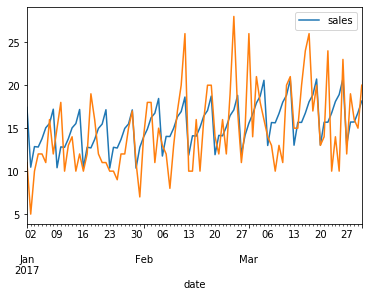

In [81]:
predictions.set_index(keys = ['date']).sort_index(ascending=True).plot()
val_set = train.loc[(train['item'] == item_num) & (train['store'] == store_num) 
                    & (train['date'] >= start_date) & (train['date'] <= end_date)]
val_set.set_index(keys = ['date']).sort_index(ascending=True)['sales'].plot()


In [74]:
SMAPE(np.array(val_set['sales']),predictions['sales'])

21.271658339376277

In [75]:
df.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=110)

In [77]:
OHE_column

NameError: name 'OHE_column' is not defined